In [1]:
# Imports
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString, Point
import matplotlib.pyplot as plt
from pyproj import Transformer, Geod

In [2]:
# Load and clean flow data
raw_flows_df = pd.read_excel('../../data/czech/data_czech.xlsx')

# Use first column as destination
raw_flows_df = raw_flows_df.rename(columns={raw_flows_df.columns[0]: 'destination'})

# Reshape long format
long_flows_df = (
    raw_flows_df
    .melt(id_vars='destination', var_name='origin', value_name='value')
    .dropna(subset=['value'])
)

# Strip and clean
long_flows_df['origin'] = long_flows_df['origin'].str.strip()
long_flows_df['destination'] = long_flows_df['destination'].str.strip()
long_flows_df = long_flows_df[long_flows_df['origin'] != long_flows_df['destination']]
flows_df = long_flows_df[['origin', 'destination', 'value']]

In [3]:
# Load regions and compute centroids
regions_gdf = gpd.read_file('../../data/czech/regions.gpkg')
regions_gdf['centroid'] = regions_gdf.representative_point()

# Manual centroid override
transformer = Transformer.from_crs("EPSG:4326", regions_gdf.crs, always_xy=True)
x_stc, y_stc = transformer.transform(14.20, 49.80)
x_olk, y_olk = transformer.transform(17.15, 49.65)
x_prh, y_prh = transformer.transform(14.50, 50.10)
x_par, y_par = transformer.transform(16.45, 49.85)#16.14476 49.91721
manual_centroids = {
    'Středočeský kraj': Point(x_stc, y_stc),
    'Olomoucký kraj': Point(x_olk, y_olk),
    'Hlavní město Praha': Point(x_prh, y_prh),
    'Pardubický kraj': Point(x_par, y_par)
}
regions_gdf['centroid'] = regions_gdf.apply(
    lambda row: manual_centroids.get(row['nazev'], row['centroid']), axis=1
)

centroids_gdf = regions_gdf[['nazev', 'centroid']].rename(columns={'nazev': 'region'})
centroids_gdf = centroids_gdf.set_geometry('centroid').set_crs(epsg=3035)
centroids_wgs = centroids_gdf.to_crs(epsg=4326)

In [4]:
# Define orthodromic line function
geod = Geod(ellps="WGS84")

def ortodrome(start, end, n_points=100):
    lon1, lat1 = start.x, start.y
    lon2, lat2 = end.x, end.y
    intermediate = geod.npts(lon1, lat1, lon2, lat2, n_points)
    return LineString([(lon1, lat1)] + intermediate + [(lon2, lat2)])

In [5]:
# Merge flows with centroids
flows_merged = (
    flows_df
    .merge(centroids_wgs, left_on='origin', right_on='region')
    .rename(columns={'centroid': 'centroid_origin'})
    .drop(columns='region')
    .merge(centroids_wgs, left_on='destination', right_on='region')
    .rename(columns={'centroid': 'centroid_destination'})
    .drop(columns='region')
)

flows_merged['geometry'] = flows_merged.apply(
    lambda r: ortodrome(r.centroid_origin, r.centroid_destination)
    if pd.notnull(r.centroid_origin) and pd.notnull(r.centroid_destination)
    else LineString(),
    axis=1
)

flows_gdf = gpd.GeoDataFrame(
    flows_merged[['origin', 'destination', 'value', 'geometry']],
    geometry='geometry', crs='EPSG:4326'
).to_crs(epsg=3035)

In [6]:
# Aggregate and compute pct
flows_gdf['pair'] = flows_gdf.apply(lambda r: tuple(sorted([r['origin'], r['destination']])), axis=1)
flows_gdf['value_total'] = flows_gdf.groupby('pair')['value'].transform('sum')
flows_gdf['pct'] = (flows_gdf['value'] / flows_gdf['value_total'] * 100).round(2)
flows_gdf = flows_gdf.drop(columns='pair')

In [7]:
# Orientation calculation

def determine_orientation(row):
    line = row.geometry
    if isinstance(line, LineString):
        start, end = line.coords[0], line.coords[-1]
        return 1 if end[1] > start[1] else -1
    return 0

flows_gdf['orientation'] = flows_gdf.apply(determine_orientation, axis=1)

In [8]:
# Trim function

def trim_line_by_pct(row):
    line = row.geometry
    pct = row.pct
    if not isinstance(line, LineString) or pct is None:
        return line
    if pct >= 100:
        return line
    target_len = line.length * (pct / 100)
    coords = []
    length = 0
    for i in range(len(line.coords) - 1):
        seg = LineString([line.coords[i], line.coords[i+1]])
        seg_len = seg.length
        if length + seg_len < target_len:
            coords.append(line.coords[i])
            length += seg_len
        else:
            rem = target_len - length
            point = seg.interpolate(rem)
            coords.append(line.coords[i])
            coords.append((point.x, point.y))
            break
    if len(coords) < 2:
        p = line.interpolate(target_len)
        return LineString([line.coords[0], (p.x, p.y)]) if p else LineString([line.coords[0]])
    return LineString(coords)

flows_gdf['geometry'] = flows_gdf.apply(trim_line_by_pct, axis=1)

In [9]:
# Export trimmed lines
flows_gdf.to_file("../../data/czech/czech_flows.gpkg", driver="GPKG", layer="trimmed_lines")

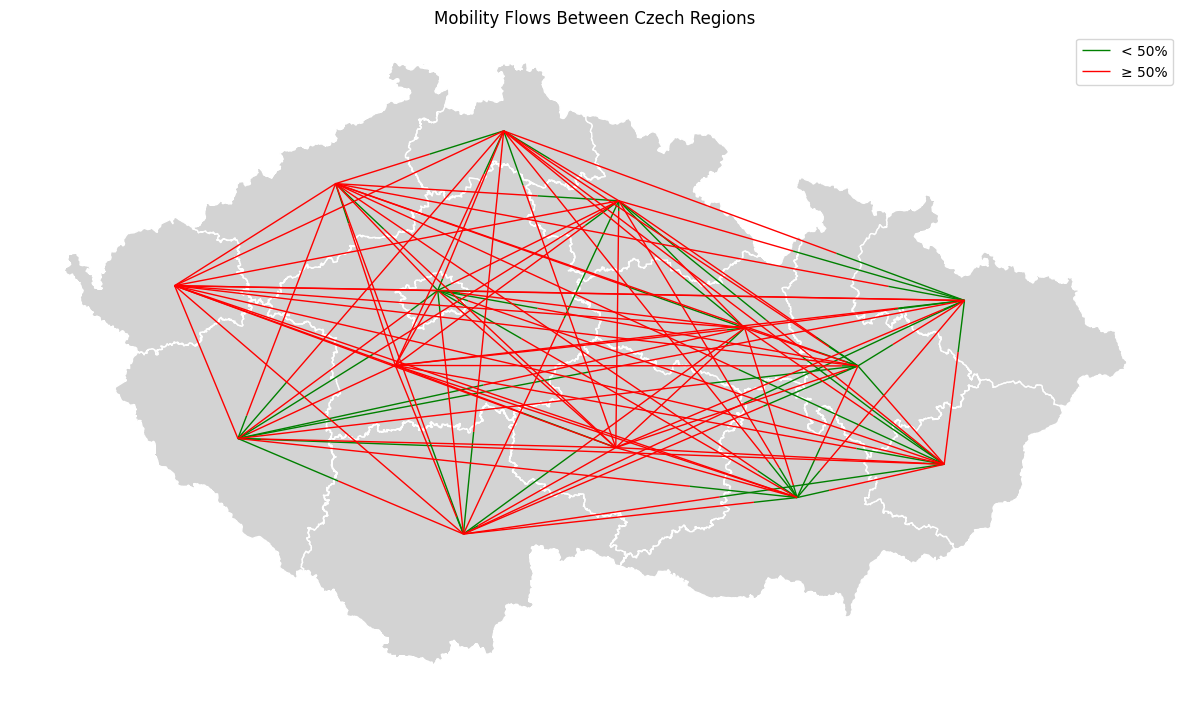

In [10]:
# Plot trimmed flows
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
regions_gdf.plot(ax=ax, color='lightgrey', edgecolor='white')
flows_gdf[flows_gdf['pct'] < 50].plot(ax=ax, color='green', linewidth=1, label='< 50%')
flows_gdf[flows_gdf['pct'] >= 50].plot(ax=ax, color='red', linewidth=1, label='≥ 50%')
ax.set_title("Mobility Flows Between Czech Regions")
ax.axis('off')
ax.legend()
plt.tight_layout()
plt.show()